In [ ]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from sklearn.metrics import (
    cohen_kappa_score,
    jaccard_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    average_precision_score
)

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random

## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [6]:
w, h = 512 ,512
border = 5

In [ ]:
ids = next(os.walk("/content/800_dataset_with_semantic_segmentation/train_images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  61


# **Data Reading and Train test split**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
import glob
train = sorted(glob.glob("/content/drive/MyDrive/SegSperm/train/images/*"))
train_mask = sorted(glob.glob("/content/drive/MyDrive/SegSperm/train/GT1_full/*.png"))
test = sorted(glob.glob("/content/drive/MyDrive/SegSperm/test/images/*"))
test_mask = sorted(glob.glob("/content/drive/MyDrive/SegSperm/test/GT1_full/*.png"))
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')
print(f'Total Test Images : {len(test)}\nTotal Test Mask Image : {len(test_mask)}')

Total Train Images : 0
Total Mask Image : 0
Total Test Images : 0
Total Test Mask Image : 0


In [ ]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)


In [ ]:
X_test = np.zeros((len(test), h, w, 3), dtype=np.float32)
y_test = np.zeros((len(test_mask), h, w, 1), dtype=np.float32)

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(test, test_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X_test[n] = x_img/255.0
  y_test[n] = mask/255.0

0it [00:00, ?it/s]

In [10]:
# Save the files in Numpy array for reusability
#np.save('/content/drive/MyDrive/SegSperm/U-net/XandY/X.npy', X)
#np.save('/content/drive/MyDrive/SegSperm/U-net/XandY/y.npy', y)
# print(X.shape, y.shape)
X = np.load('/content/drive/MyDrive/SegSperm/U-net/XandY/X.npy')
y = np.load('/content/drive/MyDrive/SegSperm/U-net/XandY/y.npy')
print(X.shape, y.shape)

(432, 512, 512, 3) (432, 512, 512, 1)


In [11]:
# Save the files in Numpy array for reusability
#np.save('/content/drive/MyDrive/SegSperm/U-net/XandYTest/X_test.npy', X_test)
#np.save('/content/drive/MyDrive/SegSperm/U-net/XandYTest/y_test.npy', y_test)
# print(X.shape, y.shape)
X_test = np.load('/content/drive/MyDrive/SegSperm/U-net/XandYTest/X_test.npy')
y_test = np.load('/content/drive/MyDrive/SegSperm/U-net/XandYTest/y_test.npy')
print(X_test.shape, y_test.shape)

(119, 512, 512, 3) (119, 512, 512, 1)


In [ ]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(388, 512, 512, 3) (388, 512, 512, 1) (44, 512, 512, 3) (44, 512, 512, 1)


129

In [12]:
X_train = X
y_train = y
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()


(432, 512, 512, 3) (432, 512, 512, 1) (119, 512, 512, 3) (119, 512, 512, 1)


60

# **Visualization the image and It masks**

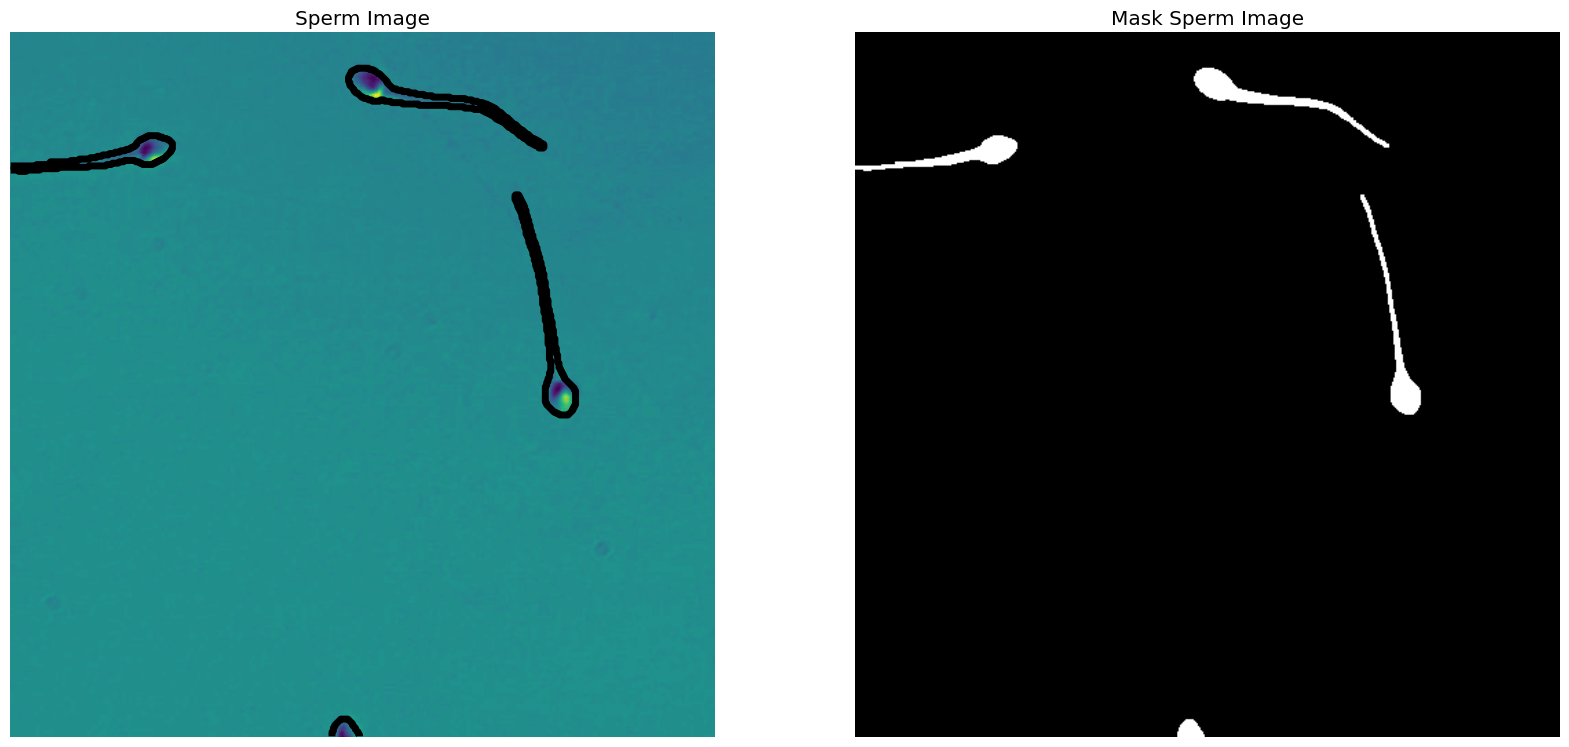

In [13]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Sperm Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Sperm Image')
ax2.set_axis_off()

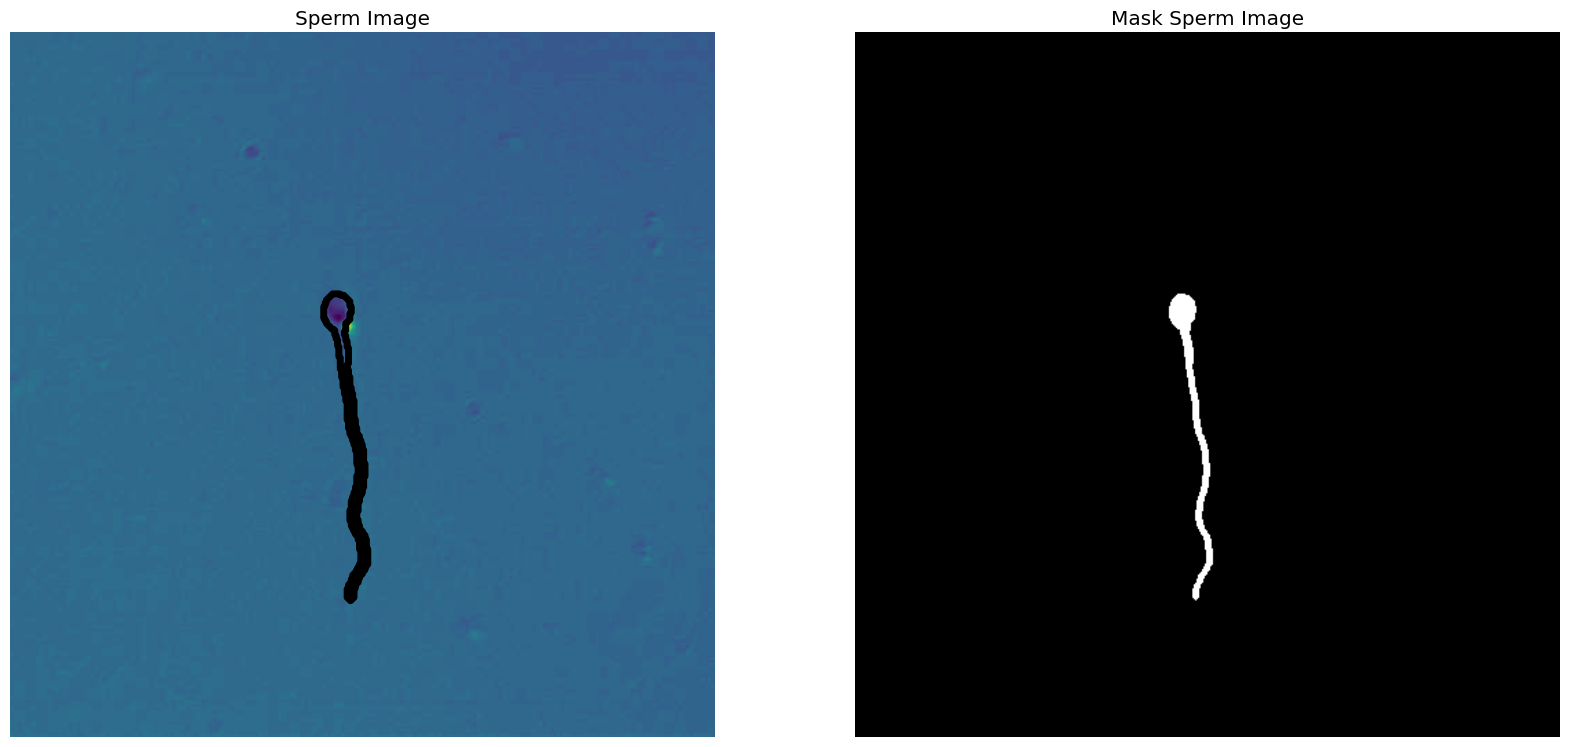

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_test))
has_mask = y_test[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_test[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_test[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Sperm Image')
ax1.set_axis_off()
ax2.imshow(y_test[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Sperm Image')
ax2.set_axis_off()

In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
# valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [3]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [4]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [14]:
from keras import backend as K
K.clear_session()

input_img = Input((h, w, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy",
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

407

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         448       ['img[0][0]']                 
                                                                                                  
 batch_normalization_1 (Bat  (None, 512, 512, 16)         64        ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 512, 512, 16)         0         ['batch_normalization_1[0]

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=300, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/300
72/72 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.9164 - auc: 0.6320 - sensitivity_at_specificity: 0.6452 - specificity_at_sensitivity: 0.6656
Epoch 1: val_loss improved from inf to 0.45732, saving model to model-Unet.h5
72/72 [==============================] - 45s 305ms/step - loss: 0.5123 - accuracy: 0.9164 - auc: 0.6320 - sensitivity_at_specificity: 0.6452 - specificity_at_sensitivity: 0.6656 - val_loss: 0.4573 - val_accuracy: 0.9890 - val_auc: 0.7241 - val_sensitivity_at_specificity: 0.7269 - val_specificity_at_sensitivity: 0.8224 - lr: 0.0010
Epoch 2/300
72/72 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.9912 - auc: 0.8046 - sensitivity_at_specificity: 0.8473 - specificity_at_sensitivity: 0.9248
Epoch 2: val_loss improved from 0.45732 to 0.24973, saving model to model-Unet.h5
72/72 [==============================] - 18s 251ms/step - loss: 0.2858 - accuracy: 0.9912 - auc: 0.8046 - sensitivity_at_specificity: 0.8473 

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
32,0.007417,0.996372,0.997870,0.997027,0.999912,0.020697,0.994282,0.929884,0.868148,0.998953,0.00010
37,0.006967,0.996562,0.998150,0.997426,0.999924,0.020744,0.994348,0.929331,0.865980,0.998976,0.00010
33,0.007241,0.996454,0.997925,0.997071,0.999923,0.020885,0.994335,0.926589,0.860305,0.998953,0.00010
34,0.007160,0.996486,0.997937,0.997064,0.999925,0.020932,0.994416,0.925767,0.858655,0.999026,0.00010
36,0.007066,0.996517,0.998135,0.997433,0.999925,0.021081,0.994219,0.928432,0.864438,0.998873,0.00010
38,0.006875,0.996595,0.998241,0.997576,0.999933,0.021099,0.994315,0.926336,0.860018,0.998953,0.00001
35,0.007096,0.996502,0.998132,0.997437,0.999927,0.021166,0.994127,0.930871,0.870487,0.998823,0.00010
40,0.006887,0.996601,0.998188,0.997475,0.999933,0.021182,0.994309,0.926346,0.860335,0.998949,0.00001
41,0.006865,0.996588,0.998196,0.997483,0.999933,0.021191,0.994316,0.925973,0.859389,0.998960,0.00001
42,0.006872,0.996588,0.998311,0.997719,0.999930,0.021202,0.994306,0.926311,0.860157,0.998942,0.00001


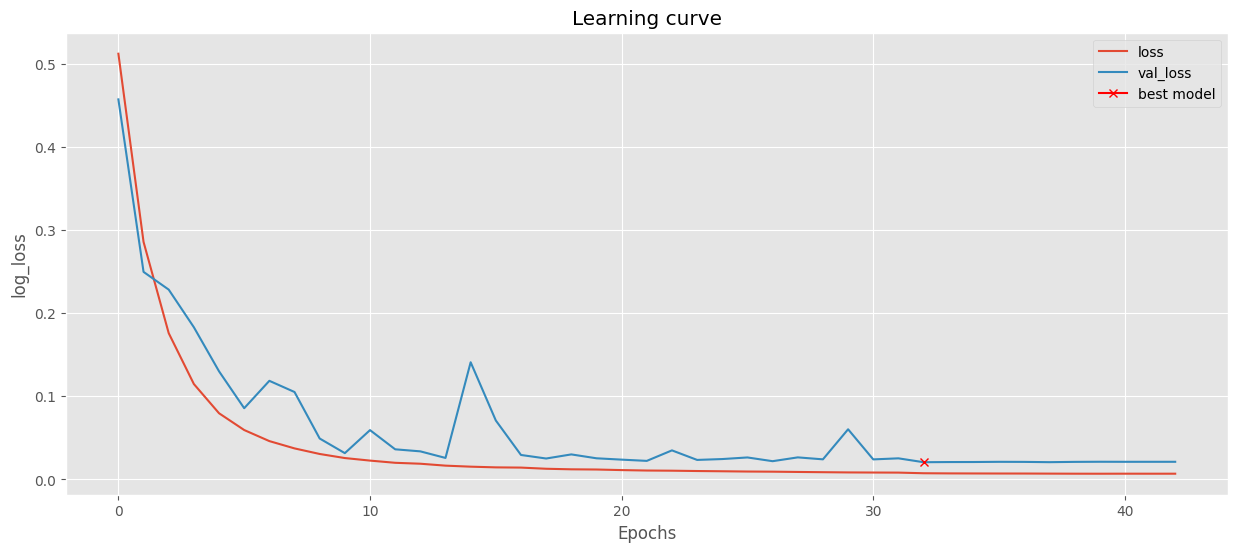

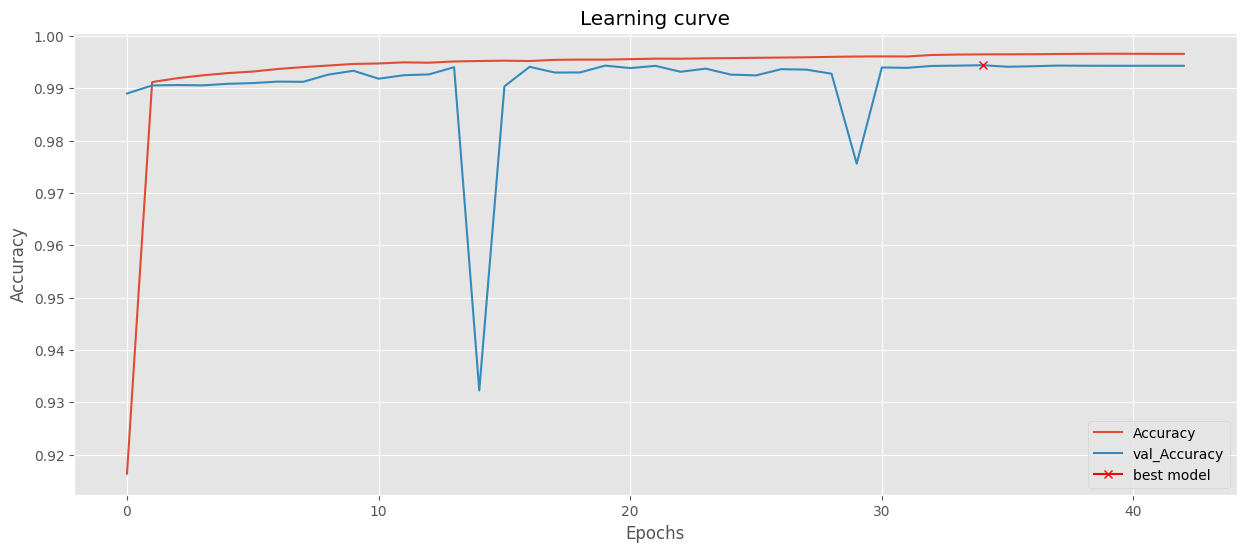

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [16]:
model.load_weights('/content/drive/MyDrive/SegSperm/U-net/model-Unet.h5')

In [17]:
model.evaluate(X_test, y_test, verbose=1)

4/4 [==============================] - 75s 16s/step - loss: 0.0207 - accuracy: 0.9943 - auc: 0.9299 - sensitivity_at_specificity: 0.8681 - specificity_at_sensitivity: 0.9990


[0.020696640014648438,
 0.9942818284034729,
 0.9298841953277588,
 0.8681477904319763,
 0.9989526271820068]

In [18]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

4/4 [==============================] - 66s 16s/step


In [19]:
# Threshold predictions
threshold = 0.5
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)
threshold = 0.5  # Możesz dostosować próg według swoich potrzeb
# Przekształć ciągłe wartości na binarne używając progu
y_test_binary = (y_test > threshold).astype(int)
y_train_binary = (y_train > threshold).astype(int)


In [20]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Sperm Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Sperm Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Sperm Image Predicted')
    ax[2].set_axis_off()

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Sperm Mask Image Predicted binary');
    ax[3].set_axis_off()

# **Predictions on training set**

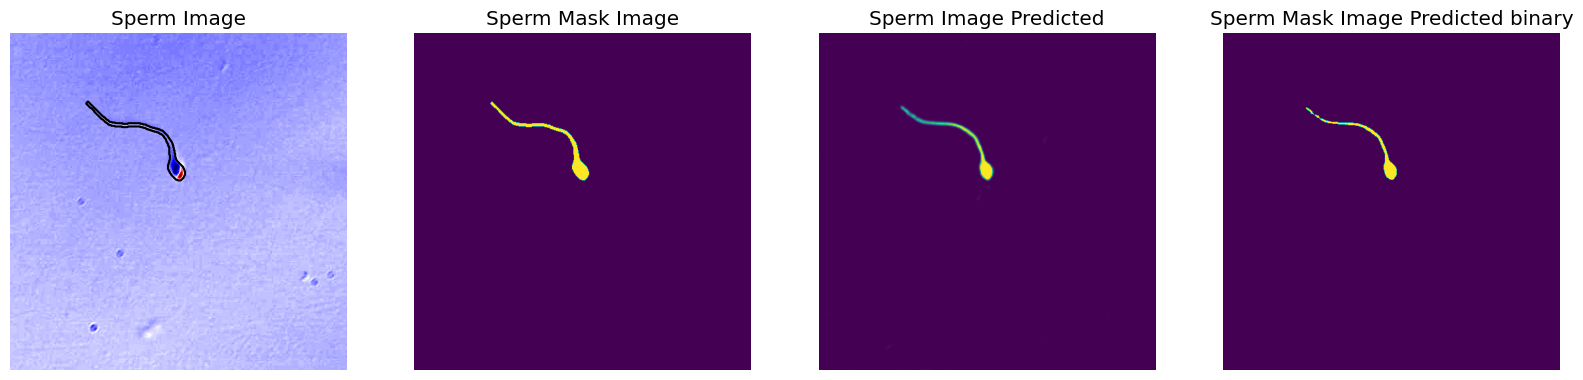

In [21]:
# Check if training data looks all right
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=14)

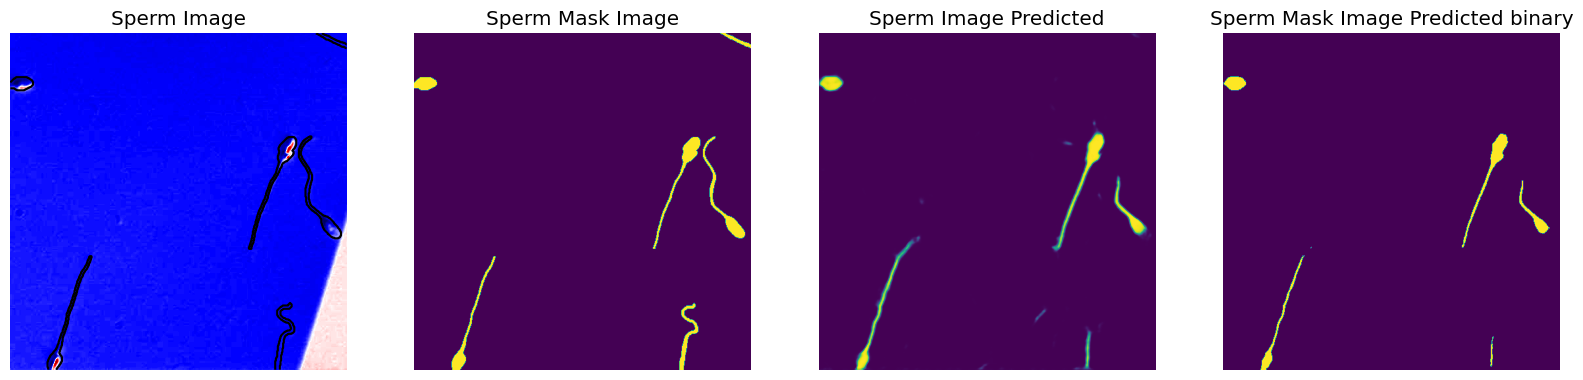

In [ ]:
plot_sample(X_test, y_test_binary, preds_val, preds_val_t)

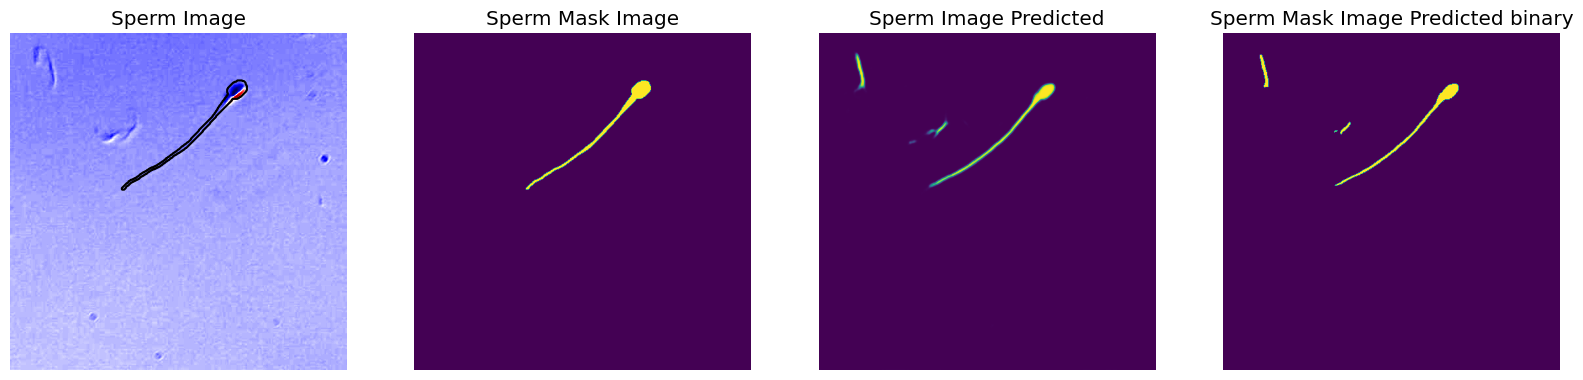

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

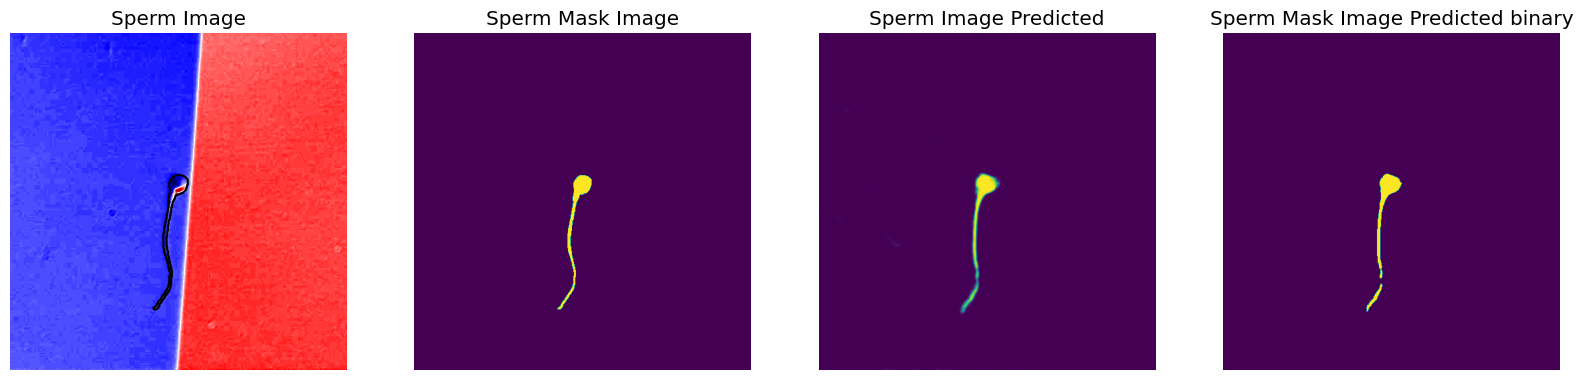

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

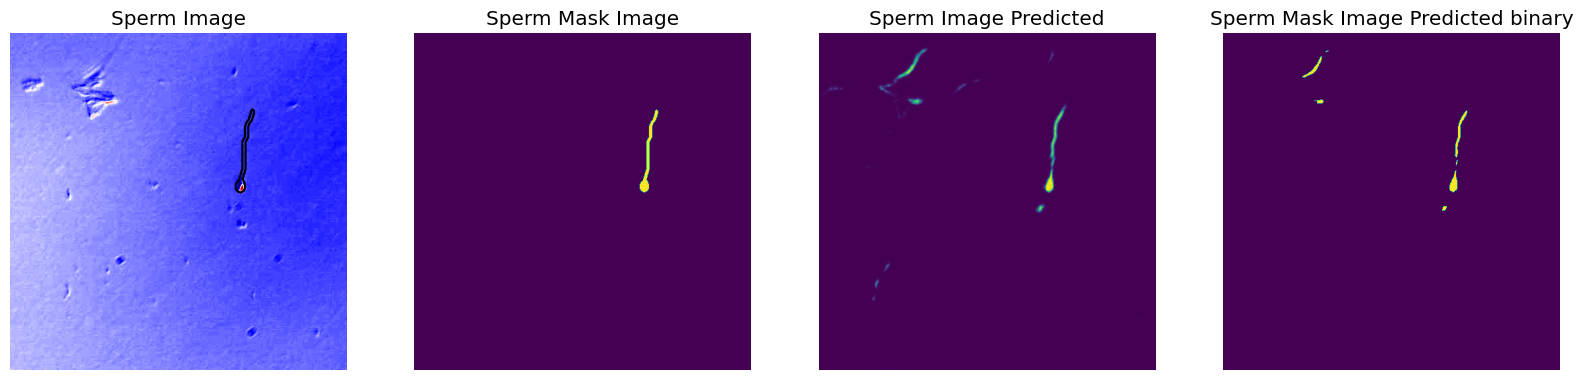

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

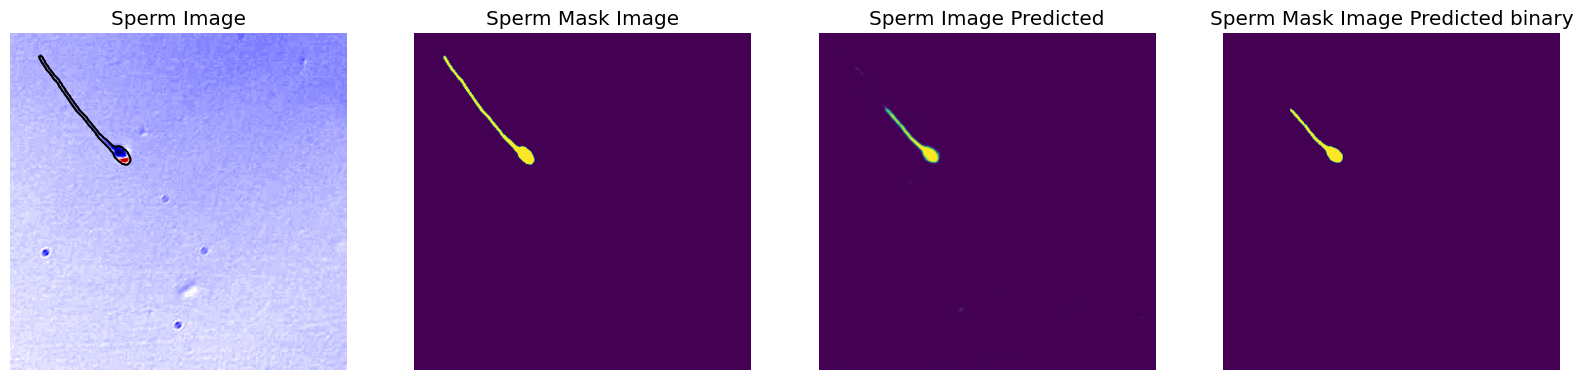

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

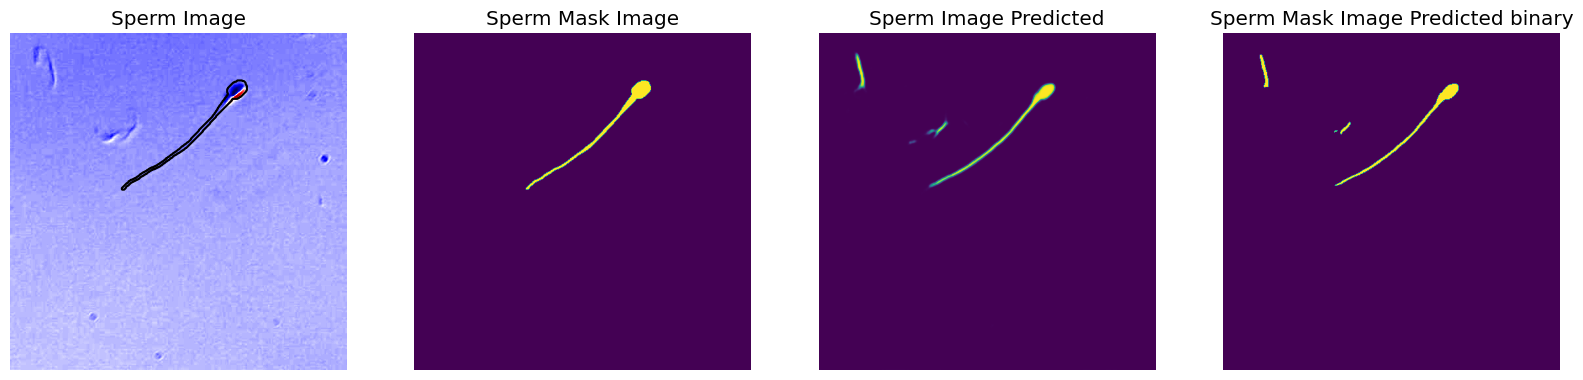

In [ ]:
plot_sample(X_test, y_test_binary, preds_val, preds_val_t)

In [26]:
Iou = jaccard_score(y_test_binary.flatten(),preds_val_t.flatten())
Ap = average_precision_score(y_test_binary.flatten(),preds_val_t.flatten())
print("Iou = {}".format(Iou))
print("Ap = {}".format(Ap))


Iou = 0.49168654242053755
Ap = 0.4469881895772343
